## Notebook 2.2. Understanding and Preprocessing of Moodle Logs

For all intents and purposes, this should be considered as the first real notebook that is part of the thesis work. In it, we will take the original student log file and perform the necessary manipulations to ensure that we have a dataset with the potential to be useful.

#### 1. A Small overview of the logs and each column

The presented logs report to interactions with the Moodle LMS:

    - Each interaction with the LMS is recorded sequentially:
        When is the action performed,
        What is the nature of the interaction,
        Where is the actor when the action is performed,
        Who performed the interaction,
        In the context of which course page,
        What is the specific link,
                
    - Each user is uniquely identified by the userID,
    - Each course is uniquely identified by the courseID,
    - Each specific interaction is recorded -> action performed and clicked url, 
    - Each click is timestamped,
    - The actor's IP is recorded,

A brief description of each column follows:

##### id
A sequentilly numbered unique identifier interactions,

##### time
A float number representation of the timestamp of the event,

##### userid
Unique numerical identifier of user -> be it student, faculty or other,

##### ip
ip adress used by the user when interactiong with the LMS system,

##### course
Unique numerical identifier of a course,

##### cmid
meaning unclear at the moment - to check with other Moodle Sources,

##### action
categorization of nature of the interaction

##### url
link user clicked on

##### info
additional descriptors added by the user

#### 2. We'll start this notebook by importing all relevant packages and data

All data is stored in the csv files that were exported in the previous notebook. 

In order to minimize unecessary steps, as we import these csv files we will immediatly remove, from each dataset:
1. The first unnamed column,
2. All columns that are entirely made of missing values - we have detected some.
3. All numerical columns that are immediatly recognied as categorical (or likely to be categorical values) are also immediatly declared as categoricals - this does not mean that, upon further assessment, other features may be converted to objects,
4. All features that display no null values and have a single value are promptly removed as well, 
5. No preprocessing of time related features is performed at this stage - namely because the features realted with time may require further assessment.

In [1]:
#import libs
import pandas as pd
import numpy as np

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm

import seaborn as sns

sns.set()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#additionally, we will also define preemptively some golbal variables that may come in handy

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

In [3]:
#loading student log data 
student_logs = pd.read_csv('../Data/R_Gonz_data_log.csv', 
                           dtype = {
                                   'id': object,
                                   'itemid': object,
                                   'userid': object,
                                   'course': object,
                                   'cmid': object,
                                   },).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1) #logs

#loading support table
support_table = pd.read_csv('../Data/R_Gonz_support_table.csv', 
                           dtype = {
                                   'assign_id': object,
                                   'courseid': object,
                                   'userid': object,
                                   }, 
                            parse_dates = ['sup_time', 'startdate']).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1) #support table

#after checking, we note that time and stime report to the same date and differ in 1 hour, hence, we will only keep the time column
#additionally, we will make the immediate conversion of time
student_logs['time'] = pd.to_datetime(student_logs['time'], unit = 's', errors = 'coerce')
student_logs.drop('stime', axis = 1, inplace = True)

### We start by taking a preliminary look at the logs

In [4]:
student_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47097824 entries, 0 to 47097823
Data columns (total 10 columns):
 #   Column  Dtype         
---  ------  -----         
 0   id      object        
 1   time    datetime64[ns]
 2   userid  object        
 3   ip      object        
 4   course  object        
 5   module  object        
 6   cmid    object        
 7   action  object        
 8   url     object        
 9   info    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 3.5+ GB


In [5]:
student_logs.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
id,47097824,47097824,1.0,1,NaT,NaT,NaT,NaT,NaT,NaT
time,47097824,NaN,NaN,NaN,2015-01-20 08:00:31.016559872,2014-06-05 17:09:07,2014-11-10 12:51:08.750000128,2015-01-17 20:12:12,2015-03-27 22:43:11,2015-07-31 03:14:09
userid,47097824,30517,0.0,3219653,NaT,NaT,NaT,NaT,NaT,NaT
ip,47097824,161783,127.0.0.1,30508698,NaT,NaT,NaT,NaT,NaT,NaT
course,47097824,5112,1.0,17715596,NaT,NaT,NaT,NaT,NaT,NaT
module,47097824,39,course,17937931,NaT,NaT,NaT,NaT,NaT,NaT
cmid,47097824,167235,0.0,34846344,NaT,NaT,NaT,NaT,NaT,NaT
action,47097824,157,view,27239500,NaT,NaT,NaT,NaT,NaT,NaT
url,47070765,754343,view.php?id=1,6303588,NaT,NaT,NaT,NaT,NaT,NaT
info,42907847,693729,1,6306585,NaT,NaT,NaT,NaT,NaT,NaT


In [6]:
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info
0,1.0,2014-06-05 17:09:07,2.0,127.0.0.1,1.0,user,0.0,login,view.php?id=2&course=1,2
1,2.0,2014-06-05 17:14:48,2.0,127.0.0.1,1.0,user,0.0,update,view.php?id=2,NaN
2,3.0,2014-06-05 17:14:48,2.0,127.0.0.1,1.0,user,0.0,update,view.php?id=2,NaN
3,4.0,2014-06-05 17:16:13,2.0,127.0.0.1,1.0,course,0.0,view,view.php?id=1,1
4,5.0,2014-06-06 07:37:19,2.0,127.0.0.1,1.0,user,0.0,login,view.php?id=2&course=1,2
...,...,...,...,...,...,...,...,...,...,...
47097819,47116816.0,2015-07-31 03:00:59,0.0,127.0.0.1,1.0,user,0.0,add,/view.php?id=81854,Cathleen Scheurich
47097820,47116817.0,2015-07-31 03:00:59,0.0,127.0.0.1,1.0,user,0.0,add,/view.php?id=81855,Sara Gil Díez
47097821,47116818.0,2015-07-31 03:00:59,0.0,127.0.0.1,1.0,user,0.0,add,/view.php?id=81856,Eduardo García Bermo
47097822,47116819.0,2015-07-31 03:14:08,0.0,127.0.0.1,635.0,role,0.0,unassign,admin/roles/assign.php?contextid=24578&roleid=5,Estudiante


In [7]:
#use this cell to write any additional piece of code that may be required

### And follow-up by looking at the support table

In [8]:
support_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221362 entries, 0 to 221361
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   assign_id         221362 non-null  object        
 1   courseid          221362 non-null  object        
 2   startdate         221362 non-null  datetime64[ns]
 3   userid            221362 non-null  object        
 4   sup_time          221362 non-null  datetime64[ns]
 5   mandatory_status  221362 non-null  float64       
 6   delivered         221362 non-null  int64         
 7   assignment_mark   221362 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 13.5+ MB


In [9]:
support_table.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
assign_id,221362,6347,98648.0,657,NaN,NaN,NaN,NaN,NaN,NaN,NaN
courseid,221362,732,2271.0,17871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
startdate,221362,NaN,NaN,NaN,2014-11-24 08:11:34.428131328,2014-07-31 22:00:00,2014-09-09 22:00:00,2014-12-01 23:00:00,2015-01-26 23:00:00,2015-07-04 22:00:00,NaN
userid,221362,14111,68626.0,131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sup_time,221362,NaN,NaN,NaN,2015-02-09 16:54:28.175721472,2014-08-24 17:36:23,2014-12-05 11:47:25,2015-02-13 14:48:49.500000,2015-04-20 20:34:12.249999872,2015-07-28 21:45:39,NaN
mandatory_status,221362.0,NaN,NaN,NaN,0.563683,0.0,0.0,1.0,1.0,1.0,0.495929
delivered,221362.0,NaN,NaN,NaN,0.614432,0.0,0.0,1.0,1.0,1.0,0.48673
assignment_mark,221362.0,NaN,NaN,NaN,0.416381,0.0,0.0,0.366337,0.833333,1.0,0.412597


In [10]:
support_table

,assign_id,courseid,startdate,userid,sup_time,mandatory_status,delivered,assignment_mark
0,588.0,18.0,2014-09-03 22:00:00,17881.0,2014-11-04 16:22:27,1.0,1,1.000000
1,588.0,18.0,2014-09-03 22:00:00,18204.0,2014-11-04 16:22:36,1.0,1,1.000000
2,588.0,18.0,2014-09-03 22:00:00,18541.0,2014-11-04 16:22:45,1.0,1,1.000000
3,588.0,18.0,2014-09-03 22:00:00,22888.0,2014-11-04 16:22:51,1.0,1,1.000000
4,588.0,18.0,2014-09-03 22:00:00,23037.0,2014-11-04 16:22:58,1.0,1,1.000000
...,...,...,...,...,...,...,...,...
221357,275678.0,5909.0,2015-07-04 22:00:00,78349.0,2015-07-28 20:06:44,0.0,1,0.592105
221358,275678.0,5909.0,2015-07-04 22:00:00,78352.0,2015-07-28 20:08:25,0.0,1,0.907895
221359,275678.0,5909.0,2015-07-04 22:00:00,78439.0,2015-07-28 20:11:42,0.0,1,0.355263
221360,275678.0,5909.0,2015-07-04 22:00:00,78442.0,2015-07-28 20:13:11,0.0,1,0.592105


In [11]:
#use this cell to write any additional piece of code that may be required

### Goal 1: 

One of the first thing to do is to consider the set of students and courses we intend to use. We have, from our support table, a list of the courses and students that we are interested in.

We can, thus, start by limiting our interaction with the courses for which we have targets - even if we do not grades for those students.

In [12]:
#We start by filtering by all courses that are in our support table
course_array = support_table['courseid'].unique()

#then, we keep logs of the courses of interest   
student_logs = student_logs[(student_logs['course'].isin(course_array)) & (student_logs['time'] >= '2014-08-24')].sort_values(by = 'time').reset_index(drop = True)

#and get the complete list of students interacting with the system - graded or not
student_courses = student_logs.filter(['course', 'userid']).drop_duplicates().reset_index(drop = True)

#take a look at slices dataset
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info
0,256537.0,2014-08-24 08:10:44,69588.0,127.0.0.1,4904.0,course,0.0,view,view.php?id=4904,4904
1,256538.0,2014-08-24 08:11:06,69588.0,127.0.0.1,4904.0,assign,203612.0,view,view.php?id=203612,Ver página de estado de las entregas propios.
2,256539.0,2014-08-24 08:11:37,69588.0,127.0.0.1,4904.0,course,0.0,view,view.php?id=4904,4904
3,256540.0,2014-08-24 08:12:02,69588.0,127.0.0.1,4904.0,scorm,202985.0,pre-view,view.php?id=202985,182
4,256541.0,2014-08-24 08:12:43,69588.0,127.0.0.1,4904.0,scorm,202985.0,view,player.php?cm=202985&scoid=934,182
...,...,...,...,...,...,...,...,...,...,...
11323358,47116784.0,2015-07-31 03:00:07,20151.0,127.0.0.1,1376.0,resource,56623.0,view,view.php?id=56623,36375
11323359,47116785.0,2015-07-31 03:00:08,20151.0,127.0.0.1,1376.0,resource,56621.0,view,view.php?id=56621,36374
11323360,47116786.0,2015-07-31 03:00:09,20151.0,127.0.0.1,1376.0,resource,56620.0,view,view.php?id=56620,36373
11323361,47116787.0,2015-07-31 03:00:10,20151.0,127.0.0.1,1376.0,resource,56619.0,view,view.php?id=56619,36372


In [13]:
student_logs.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
id,11323363,11323363,256537.0,1,NaT,NaT,NaT,NaT,NaT,NaT
time,11323363,NaN,NaN,NaN,2015-01-24 21:26:23.219063040,2014-08-24 08:10:44,2014-11-13 16:15:04,2015-01-20 16:07:28,2015-04-09 12:05:04,2015-07-31 03:00:10
userid,11323363,16786,3289.0,113025,NaT,NaT,NaT,NaT,NaT,NaT
ip,11323363,86099,127.0.0.1,7192201,NaT,NaT,NaT,NaT,NaT,NaT
course,11323363,732,4213.0,208515,NaT,NaT,NaT,NaT,NaT,NaT
module,11323363,32,course,4069502,NaT,NaT,NaT,NaT,NaT,NaT
cmid,11323363,46966,0.0,5980559,NaT,NaT,NaT,NaT,NaT,NaT
action,11323363,134,view,7542013,NaT,NaT,NaT,NaT,NaT,NaT
url,11315247,298242,/report/grader/index.php?id=4213,137240,NaT,NaT,NaT,NaT,NaT,NaT
info,10940624,283574,Ver página de estado de las entregas propios.,809564,NaT,NaT,NaT,NaT,NaT,NaT


From this filtering process, we get **11 359 952 recorded interactions**, performed by **16 805** unique students in the context of **732 curricular units**.

We will be able to go further in our filtering efforts, but, beforehand, we may create some exploratory visualizations that will be able to assist us.

#### Small visualization: Weekly clicks per course
We know that the conditions from course to course vary wildly. 
For the purposes of a more thorough understanding of the data, we can see how clicks for each course vary, from course to course, through time.

In [14]:
#first, we sort the courses by the start date. Then, we'll get the index of each 
sorting_hat = support_table[['courseid', 'startdate']].drop_duplicates().sort_values(by = 'startdate').reset_index(drop = True)
sorting_hat.reset_index(inplace = True)
sorting_hat = sorting_hat.set_index('courseid').to_dict()['startdate'] 

#Then, when it comes to logs, we aggregate by week
grouped_data = student_logs.groupby([pd.Grouper(key='time', freq='W'), 'course']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index ='course', 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data['Course'].map(sorting_hat)
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index('Course', drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Course,,,,,,,,
4914,47.0,298.297872,276.137876,2.0,67.50,215.0,469.00,1071.0
5051,45.0,108.088889,135.061909,1.0,9.00,49.0,133.00,481.0
5050,50.0,504.940000,458.134924,3.0,271.25,375.5,655.00,2720.0
985,46.0,116.608696,132.938495,2.0,12.25,65.0,174.00,511.0
1000,32.0,101.437500,122.628981,1.0,3.75,46.5,168.25,447.0
...,...,...,...,...,...,...,...,...
5836,4.0,123.500000,165.619041,1.0,4.00,69.5,189.00,354.0
5832,6.0,55.833333,71.479834,5.0,6.75,15.0,107.25,158.0
5838,3.0,226.333333,222.003003,5.0,115.00,225.0,337.00,449.0


In [15]:
grouped_data

Date (week),2014-08-24,2014-08-31,2014-09-07,2014-09-14,2014-09-21,2014-09-28,2014-10-05,2014-10-12,2014-10-19,2014-10-26,...,2015-05-31,2015-06-07,2015-06-14,2015-06-21,2015-06-28,2015-07-05,2015-07-12,2015-07-19,2015-07-26,2015-08-02
Course,,,,,,,,,,,,,,,,,,,,,
4914,34.0,362.0,677.0,864.0,449.0,486.0,983.0,582.0,712.0,503.0,...,2.0,70.0,NaN,208.0,424.0,11.0,5.0,NaN,153.0,4.0
5051,NaN,118.0,407.0,481.0,133.0,288.0,248.0,113.0,421.0,210.0,...,11.0,77.0,40.0,10.0,14.0,74.0,4.0,9.0,4.0,NaN
5050,22.0,293.0,299.0,2720.0,1354.0,513.0,675.0,487.0,815.0,474.0,...,341.0,530.0,330.0,293.0,493.0,28.0,57.0,7.0,3.0,19.0
985,NaN,300.0,132.0,367.0,483.0,363.0,177.0,46.0,97.0,219.0,...,3.0,8.0,19.0,16.0,12.0,NaN,NaN,2.0,NaN,63.0
1000,NaN,10.0,187.0,88.0,91.0,278.0,195.0,419.0,162.0,97.0,...,NaN,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,354.0,134.0,NaN,NaN,NaN,NaN,NaN
5832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,158.0,18.0,137.0,5.0,NaN,NaN,NaN,NaN,NaN
5838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,225.0,449.0,NaN,NaN,NaN,NaN,NaN


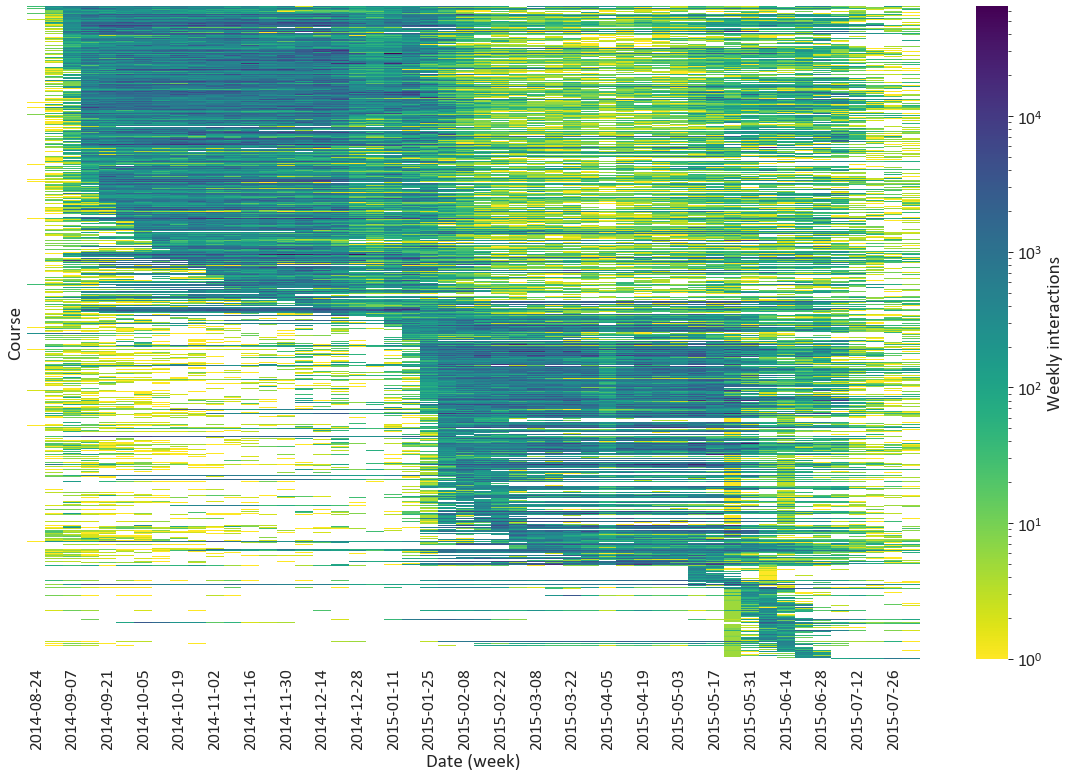

In [16]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

# Define the date format

#here, we are plotting the first
heat1 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})


fig = heat1.get_figure()
fig.savefig('../Images/exploratory_course_weekly_clicks_heatmap.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat1

**We can, additionally**, make some additional observations that may come in handy in the future:

a. How many students are attending each course,

b. How many courses is each student attending,

This knowledge will allow us make additional filtering decisions to enhance our sample.

In [17]:
#we can compute the number of students attending each course, and the number of courses each student is attending
class_list = student_courses.groupby('course')['userid'].count().to_frame().rename(columns = {'userid' : 'Users per course'})
enrollment_size = student_courses.groupby('userid')['course'].count().to_frame().rename(columns = {'course' : 'Courses per User'})

**A. How many students are attending each course?**

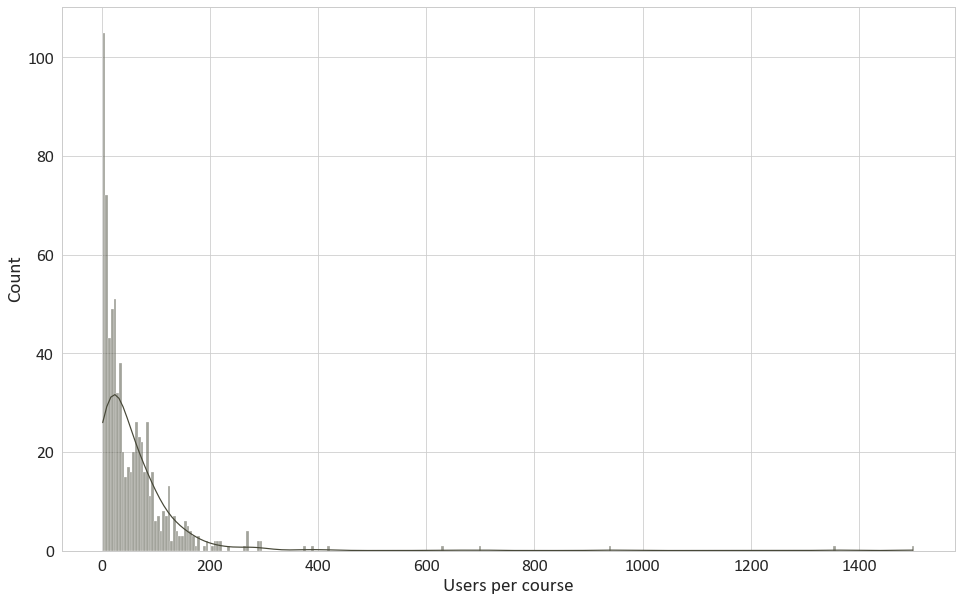

In [19]:
#settub
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)

#a number of students per course
#student_courses.rename(columns = {'userid' : 'Students per course'}, inplace = True)

#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
hist1 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist1.get_figure()
fig.savefig('../Images/hist1_students_per_course_bin_5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist1

**There is a very significant number of courses with between 1 and 10 students**


**B. In how many courses is each student enrolled?**

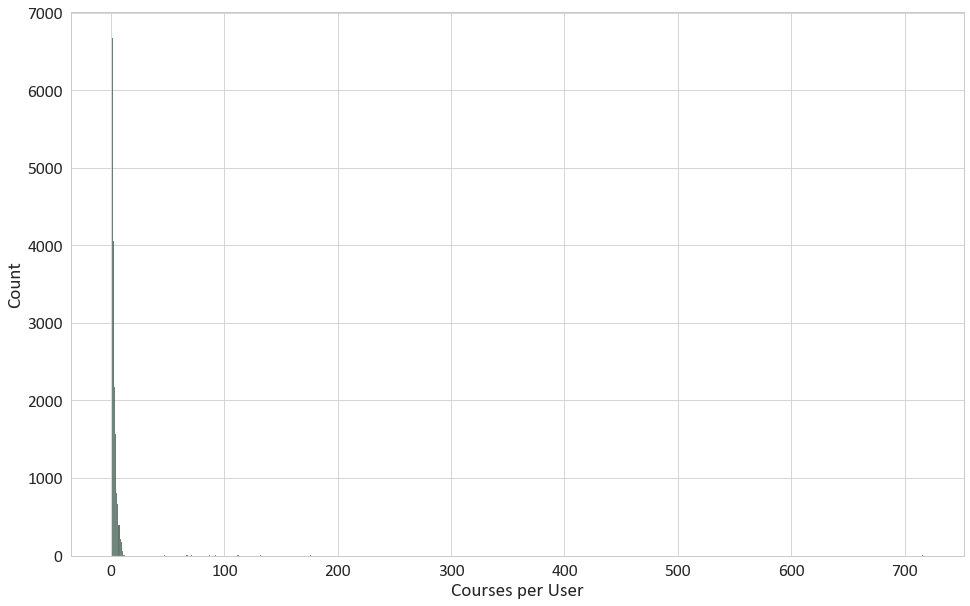

In [20]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
hist2 = sns.histplot(data= enrollment_size, 
        x='Courses per User', color= course_color, discrete = True, fill = True)

fig = hist2.get_figure()
fig.savefig('../Images/hist2_courses_per_student course_bin_1.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist2

Depending on the course in question, it is possible for it to have 1 registered user vs almost 700.
Additionally, we can also see that there is a significant number of studentsd attending a single course (over 6000).

To some extent, most courses have some degree of interaction no matter how small.

We can see that many of the interactions start in late August, early September - the start of the school year. 
When it comes to different disciplines we can also discern different the most common starting points:
- Early September
- End of January/Start of February

Additionally, many courses seem, at least on a preliminary level, be consistent with the split between semesters and trimesters.

### Goal 2: To estimate course end-date

Moodle provides the start date of each course. However, it does not provide an end-date. 
The authors of the Riestra González paper gave us 



A second observation that is consistent with our intuition is that interactions occur earlier in courses that start earlier. We still do not have a clear picture on the size (in terms of students) of the different courses.

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(student_logs_actions['action'].value_counts())

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(student_logs_actions['module'].value_counts())

In [ ]:
# we get to create a pivot-table that associates students and the courses they are attending
student_list = pd.pivot_table(support_table, index='userid', columns = 'courseid', values = 'assign_id',
                    aggfunc='count')

# we use the describe command to get the course-level aggregate statistics
# count -> number of students attending, mean is the average number of clicks performed by each student 
student_count = student_list.describe(include = 'all').T.sort_values(by = 'count', ascending = False)['count'].reset_index()

#from here, we can create a dict that associates each course to the number of students attending the course
student_count = student_count.set_index('courseid').to_dict()['count']

By now, we know, generally:

- all courses that had graded assignments (i.e. whose max assignment grade was not 0),
- all students that were registered in the curricular unit and performed, at the very least, one action in the logs,
- all activity logs performed by students in the context of the curricular units

### Second step. Calculate support information
While our logs are note entirely consistent with the findings of the R. Gonzalex paper, we can now start to dig deeper into the support information to obtain the remaining variables of interest.

**First**: to classify whether different assignments were mandatory or not

The authors of the paper focused made a split between mandatory and optional assignments. In their view, any assignment whose submittal rate (relative to the number of students attending the course) is 40% or under would be considered an optional assignment.

We can, in some capacity, partially repeat the steps performed in the previous pivot-table and make the option/mandatory classification of each assignment.

In [ ]:
# we get to create a pivot-table that associates assignments and the courses are asked on
assign_number = pd.pivot_table(support_table.dropna(), index= 'userid', columns = ['courseid', 'assign_id'], values = 'finalgrade',
                    aggfunc='count')

# we use the describe command to get the course-level aggregate statistics
# count -> number of students delivering the assignment, mean is the average number of students delivering the assignment 
assign_number = assign_number.describe(include = 'all').T.sort_values(by = 'count', ascending = False)['count'].reset_index()

#from her, we can create 2 columns: i) one with the number of students attending the course
assign_number['registered_students'] = assign_number['courseid'].map(student_count)

#then, we can calculate the percentage of assignments delivered relative to the number of attending students
assign_number['%_submissions'] = assign_number['count'] / assign_number['registered_students']

#finally, we classify each assignment as mandatory vs non-mandatory (over 40% submission rates)
assign_number['mandatory_status'] = np.where(assign_number['%_submissions'] > 0.4, 1, 0)

#from here, we can create a dict that associates each course to the number of students attending the course
mandatory_status = assign_number.set_index('assign_id').to_dict()['mandatory_status']

del assign_number

We now have assigned the mandatory status to different assignments. We will not use this knowledge immediatly, but we will need it later. What it allows us is the ability to perform new computations.

**Second**: Enhance the cleaning of unnecessary assignments and courses. We can now perform 2 distinct and important operations:

1st - identify whether the students made the delivery of the assignment or not - nans vs non nans

2nd - give every nan the classification of 0.

3rd - verify whether any assignments have an average finalgrade of 0 - these are meaningless curricular units for us.

In [ ]:
# check whether the assignment was delivered by the student or not
support_table['delivered'] = np.where(support_table['finalgrade'].isna(), 0, 1)

#now, we fill the nas of finalgrade with 0
support_table.fillna(0, inplace = True)

#as a final note, we can now verify which assignments/courses we can exclude
#criteria 1: avg finalgrade = 0
#criteria 2 -> if all assignments have average grade 0, the course can be excluded
exclusion_table = support_table.groupby(['courseid', 'assign_id']).agg({
                                                    'userid': 'count',
                                                    'finalgrade' : 'mean',
                                                    'rawgrademax' : 'mean',
                                                    },
                                                    )

# then, we keep solely the assignments that were 

In [ ]:
exclusion_table.describe(include = 'all', datetime_is_numeric = True).T

In [ ]:
exclusion_table

In [ ]:
exclusion_table.describe(include = 'all', datetime_is_numeric = True).T

In [ ]:
exclusion_table

In [ ]:
a['count']

In [ ]:
student_logs_actions.groupby([
                                        'course',
                                        #'userid',
                                        ],
                                        as_index = False).count()

Defining mandatory assignments vs non-mandatory assignments:

The authors of the paper defined the mandatory assignments were all assignments with a submission rate of over 40%.

In [ ]:
#records to keep for export - eventually
student_list # pivot table with counts of interactions of students for a course
student_count
mandatory_status
student_logs_actions #logs with student actions performed in the context of the course

### Additional Feature Engineering

#### Done

From now on we will always work with df_treated in the future notebooks. 